`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   

# Лабораторная работа №6: Машины опорных векторов. 

В практических примерах ниже показано:    
* как классифицировать данные с помощью модели SVM
* как использовать конвейеры для подгонки модели и применения её к новым даннымё

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: множественная линейная регрессия 

# Вариант 1 
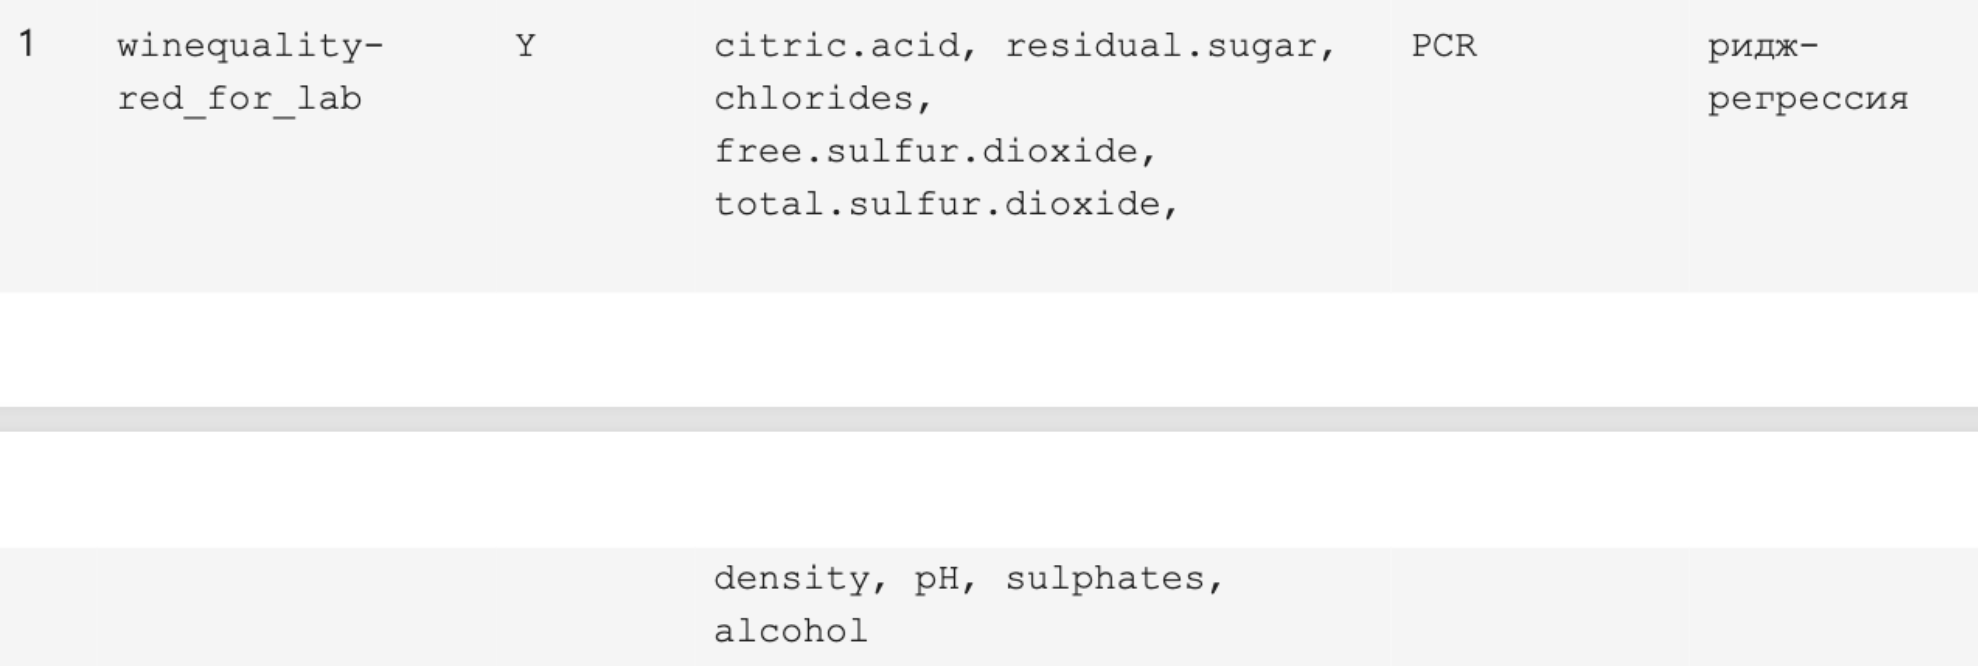

# Указания к выполнению


## Загружаем пакеты

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка символьных показателей
from sklearn.preprocessing import LabelEncoder
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency, t
#  для таймера
import time

# загрузка пакетов: модели ------------------------------------------------- 
# SVM
from sklearn.svm import SVC
# логистическая рагрессия
from sklearn.linear_model import LogisticRegression 
# стандартизация
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# конвейеры
from sklearn.pipeline import make_pipeline
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split 
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# сводка по точности классификации
from sklearn.metrics import classification_report

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree


# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier

# для теста хи-квадрат
import scipy


In [2]:
# константы
#  ядро для генератора случайных чисел
my_seed = 1
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Данные по качеству 1599 красных вин. Задача: спрогнозировать высокое / низкое качество вина. Источник данных: статья *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis* [Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.](http://www3.dsi.uminho.pt/pcortez/wine5.pdf). Набор данных был загружен из репозитория UCI (<https://archive.ics.uci.edu/ml/datasets/wine+quality>) 12.10.2021.    

## Список столбцов файла:   
* `Y` – целевая переменная: 1 = высокое качество (`quality` > 5), 0 = низкое (`quality` <= 5). 
* `citric_acid` – содержание лимонной кислоты;  
* `residual_sugar` – остаточный сахар;  
* `chlorides` – содержание хлоридов;  
* `free_sulfur_dioxide` – содержание диоксида серы в свободном виде;  
* `total_sulfur_dioxide` – общее содержание диоксида серы;  
* `density` – плотность;  
* `pH` – кислотность; 
* `sulphates` – содержание сульфатов;  
* `alcohol` – содержание алкоголя;  


* `fixed_acidity` – постоянная кислотность;  НЕ НУЖНО
* `volatile_acidity` – переменная кислотность;  НЕ НУЖНО
* `quality` – балльная оценка качества вина, от 0 до 10;  НЕ НУЖНО
* `target` – целевая переменная: класс вина.  

Загружаем данные во фрейм и выясняем их размерность.  

In [3]:
# загружаем таблицу и превращаем её во фрейм
DF_all = pd.read_csv('https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/winequality-red_for_lab.csv')

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (1599, 13)


In [4]:
# DF_all = DF_all.drop(["fixed_acidity", "volatile_acidity", "quality"], axis = 1)

In [5]:
DF_all.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,Y
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [6]:
# типы столбцов
DF_all.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Y                         int64
dtype: object

In [7]:
DF_all.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Y                       0
dtype: int64

##### Отложим 15% наблюдений для прогноза.  

In [8]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [9]:
# первые 5 строк фрейма
DF.iloc[:].head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,Y
75,8.8,0.41,0.64,2.2,0.093,9.0,42.0,0.99860,3.54,0.66,10.5,5,0
1283,8.7,0.63,0.28,2.7,0.096,17.0,69.0,0.99734,3.26,0.63,10.2,6,1
408,10.4,0.34,0.58,3.7,0.174,6.0,16.0,0.99700,3.19,0.70,11.3,6,1
1281,7.1,0.46,0.20,1.9,0.077,28.0,54.0,0.99560,3.37,0.64,10.4,6,1
1118,7.1,0.39,0.12,2.1,0.065,14.0,24.0,0.99252,3.30,0.53,13.3,6,1


In [10]:
DF.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,Y
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.335026,0.526943,0.270338,2.517991,0.087855,15.948492,46.684695,0.996751,3.307851,0.659051,10.406672,5.632818,0.535688
std,1.745702,0.180487,0.194694,1.382336,0.048463,10.462022,32.848989,0.001891,0.152771,0.170558,1.065804,0.803058,0.498908
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000,3.000000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995610,3.210000,0.550000,9.500000,5.000000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996720,3.310000,0.620000,10.100000,6.000000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,22.000000,63.000000,0.997825,3.400000,0.730000,11.100000,6.000000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.000000


# Преобразование исходных данных и построение моделей
## Стандартизация и переход к главным компонентам

В качестве альтернативных моделей рассмотрим SVM с различными вариантами ядер и логистическую регрессию. Причём предварительно преобразуем пространство исходных показателей с помощью метода главных компонент.

In [11]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, 0:12].values)

# оцениваем объяснённую главными компонентами дисперсию
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
    np.around(frac_var_expl, 3),
    '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.261 0.183 0.143 0.103 0.082 0.056 0.05  0.042 0.034 0.027 0.015 0.005] 
Общая сумма долей: 1.0


Таким образом, первые две главные компоненты объясняют 44.4% разброса 9 объясняющих переменных.
Теперь объединим функции-преобразователи и оценщики в конвейер с помощью `Pipeline` и оценим точность логистической регрессии с помощью перекрёстной проверки.

## Модель логистической регрессии с перекрёстной проверкой

In [12]:
# данные для обучения моделей
X_train = DF.iloc[:, 0:12] 
y_train = DF.iloc[:, -1]

# объединяем в конвейер шкалирование, ГК с 2 компонентами и логит
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression(random_state = my_seed, 
                                           solver = 'lbfgs'))

# будем сохранять точность моделей в один массив
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator = pipe_lr, X = X_train, y = y_train, 
                     cv = 5, scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3)) 
score_models.append('sc_pca_logit')
print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели sc_pca_logit : 0.821


## SVM с перекрёстной проверкой

Построим несколько вариантов модели SVM с различными ядерными функциями.

In [13]:
pipe_svc = make_pipeline(StandardScaler(), 
                         SVC(random_state = my_seed))

# настроим параметры SVM с помощью сеточного поиска
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0] 
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__degree' : [2, 3],
               'svc__kernel': ['poly']}]

# разбиения для перекрёстной проверки
kfold = KFold(n_splits = 5, random_state = my_seed, shuffle = True)
gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, 
                  scoring = 'accuracy', refit = True, cv = kfold, 
                  n_jobs = -1)

# таймер
tic = time.perf_counter()

# запускаем сеточный поиск
gs = gs.fit(X_train, y_train)

# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 20.97 секунд


In [14]:
# точность лучшей модели
np.around(gs.best_score_, 3)

1.0

In [15]:
# параметры лучшей модели
# * ядерная функция 
gs.best_estimator_.get_params()['svc__kernel']

'linear'

In [16]:
# * параметр регуляризации
gs.best_estimator_.get_params()['svc__C']

0.01

In [17]:
# * коэффициент ядерной функции (для ядер 'rbf', 'poly' и 'sigmoid')
gs.best_estimator_.get_params()['svc__gamma']

'scale'

In [18]:
# * степень полинома (для ядра 'poly')
gs.best_estimator_.get_params()['svc__degree']

3

In [19]:
# gs.cv_results_['params']

In [20]:
# gs.cv_results_['mean_test_score']

In [21]:
score.append(np.around(gs.best_score_,3))
score_models.append('sc_pca_svc')

print('Acc с перекрёстной проверкой','\nдля модели',score_models[1],':',score[1])

Acc с перекрёстной проверкой 
для модели sc_pca_svc : 1.0


# Метод kNN (KNeighborsClassifier)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [23]:
k_range = list(range(1,25))
weight_options = ["uniform", "distance"]

pipe_knn = Pipeline(steps=[('standard', StandardScaler()), ('PCA', PCA(n_components = 2)), ('knn', KNeighborsClassifier())])
param_grid = {
    'knn__n_neighbors': list(range(1,25))
}

knn = KNeighborsClassifier()

# разбиения для перекрёстной проверки
kfold = KFold(n_splits = 5, random_state = my_seed, shuffle = True)

grid = GridSearchCV(pipe_knn, param_grid = param_grid, scoring = 'accuracy', cv = kfold)

# таймер
tic = time.perf_counter()
# запускаем сеточный поиск
grid.fit(X_train,y_train)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 2.92 секунд


In [24]:
score.append(np.around(grid.best_score_,3))
score_models.append('sc_pca_knn')

print('Acc с перекрёстной проверкой','\nдля модели',score_models[2],':',score[2])

Acc с перекрёстной проверкой 
для модели sc_pca_knn : 0.815



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [25]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,sc_pca_logit,0.821
1,sc_pca_svc,1.000
2,sc_pca_knn,0.815


Cамой точной оказывается модель SVM с перекрёстной проверкой. Сделаем прогноз на отложенные наблюдения.   

In [26]:
# прогноз с помощью лучшей модели ансамбля с SVM
y_hat=gs.best_estimator_.predict(X=DF_predict.iloc[:, 0:12])
# точность# характеристики точности
print(classification_report(DF_predict.iloc[:,-1],y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00       127

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



# Источники 

1. Джеймс Г., Уиттон Д., Хасти Т., Тибширани Р. Введение в статистическое обучение с примерами на языке R. Пер. с англ. С.Э. Мастицкого – М.: ДМК Пресс, 2016 – 450 с.  
1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. *Tong Wang*, *Cynthia Rudin*, *Finale Doshi-Velez*, *Yimin Liu*, *Erica Klampfl*, *Perry MacNeille* A Bayesian Framework for Learning Rule Sets for Interpretable Classification / Journal of Machine Learning Research 18 (2017) 1-37. URL: <https://jmlr.org/papers/volume18/16-003/16-003.pdf>  
1. *George Pipis* How to Run the Chi-Square Test in Python / medium.com. URL: <https://medium.com/swlh/how-to-run-chi-square-test-in-python-4e9f5d10249d>   
1. *Bernd Klein* What are Decision Trees? / python-course.eu. URL: <https://www.python-course.eu/Decision_Trees.php>  
1. Pruning decision trees - tutorial / kaggle.com. URL: <https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial>  
1. Post pruning decision trees with cost complexity pruning / scikit-learn.org. URL: <https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html>  
1. *Piotr Płoński* Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python / mljar.com. URL: <https://mljar.com/blog/visualize-decision-tree/>  
1. Random Forest Feature Importance Plot / www.analyseup.com. URL: <https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html>  